<a href="https://colab.research.google.com/github/Sujal350/PINN-for-heat-transfer/blob/main/Copy_of_PINN_for_Heat_Transfer_without_Training_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# **Define the PINN model**

In [ ]:
# Define the PINN model (a simple neural network)
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)  # Output: Scalar field (e.g., pressure, temperature)

    def forward(self, x):
        x = torch.sin(self.fc1(x))
        x = torch.sin(self.fc2(x))
        return self.fc3(x)

# **Define the governing equation (PDE) for the system**

In [ ]:
# Example: The heat equation dT/dt = alpha * d2T/dx2
def pde_residual(model, x, t):
    # Compute the derivatives of T with respect to x and t
    T = model(torch.cat([x, t], dim=1))  # Model output for temperature (or other field)

    # Compute derivatives (using automatic differentiation)
    T_xx = torch.autograd.grad(T, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_xx = torch.autograd.grad(T_xx, x, grad_outputs=torch.ones_like(T_xx), create_graph=True)[0]

    T_t = torch.autograd.grad(T, t, grad_outputs=torch.ones_like(T), create_graph=True)[0]

    # PDE Residual (example for heat equation: dT/dt - alpha * d2T/dx2 = 0)
    alpha = 0.01  # Diffusion coefficient
    residual = T_t - alpha * T_xx

    return residual

# **Generate collocation points and Loss**

In [ ]:
# Generate collocation points
def generate_collocation_points(domain_size, num_points):
    x = np.random.uniform(0, domain_size, num_points)
    t = np.random.uniform(0, 1, num_points)  # Example: time between 0 and 1
    return torch.tensor(np.vstack([x, t]).T, requires_grad=True, dtype=torch.float32)

# Loss function
def loss_function(model, collocation_points):
    x = collocation_points[:, 0:1]
    t = collocation_points[:, 1:2]

    # PDE residual loss
    residual = pde_residual(model, x, t)
    pde_loss = torch.mean(residual**2)

    # Boundary and initial condition loss (example: T(0,t) = 0, T(x,0) = 0)
    # You would need to define appropriate BCs/ICs for your system here.
    bc_loss = 0  # Placeholder, add real BC/IC losses

    total_loss = pde_loss + bc_loss
    return total_loss

# **Define the model and optimizer**

In [ ]:
# Define the model and optimizer
input_dim = 2  # Input: (x, t)
hidden_dim = 64
model = PINN(input_dim, hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# **Training loop**

In [ ]:
num_epochs = 10000
domain_size = 1  # Example domain size for x
num_points = 1000  # Number of collocation points

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Generate collocation points
    collocation_points = generate_collocation_points(domain_size, num_points)

    # Calculate the loss
    loss = loss_function(model, collocation_points)

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.03888256847858429
Epoch 1000, Loss: 1.3173402635402454e-07
Epoch 2000, Loss: 4.577110246373195e-08
Epoch 3000, Loss: 2.823626310544114e-08
Epoch 4000, Loss: 1.016385340335546e-06
Epoch 5000, Loss: 1.0315440057695469e-08
Epoch 6000, Loss: 9.578371162888288e-08
Epoch 7000, Loss: 7.187941353237193e-09
Epoch 8000, Loss: 3.984747642959974e-09
Epoch 9000, Loss: 1.905475777164156e-09


# **Visualization Code**

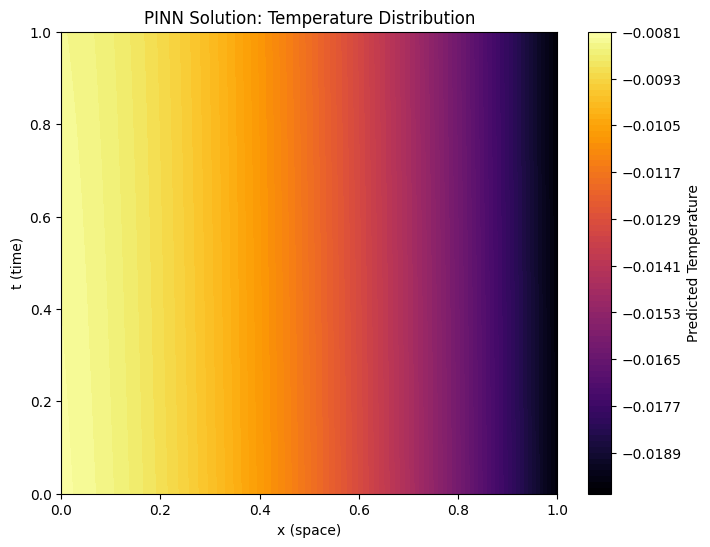

In [ ]:
import matplotlib.pyplot as plt

# Define a grid of (x, t) values for prediction
x_vals = np.linspace(0, 1, 100)
t_vals = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_vals, t_vals)

# Flatten and prepare inputs for the model
x_flat = X.flatten()
t_flat = T.flatten()
input_tensor = torch.tensor(np.vstack([x_flat, t_flat]).T, dtype=torch.float32)

# Get model predictions
with torch.no_grad():
    model.eval()
    T_pred = model(input_tensor).numpy().flatten()

# Reshape the output back to the 2D grid shape
T_pred_grid = T_pred.reshape(100, 100)

# Plot the results
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, T, T_pred_grid, levels=100, cmap='inferno')
plt.colorbar(contour, label="Predicted Temperature")
plt.xlabel("x (space)")
plt.ylabel("t (time)")
plt.title("PINN Solution: Temperature Distribution")
plt.show()


# **Heatmap (2D Color Map)**

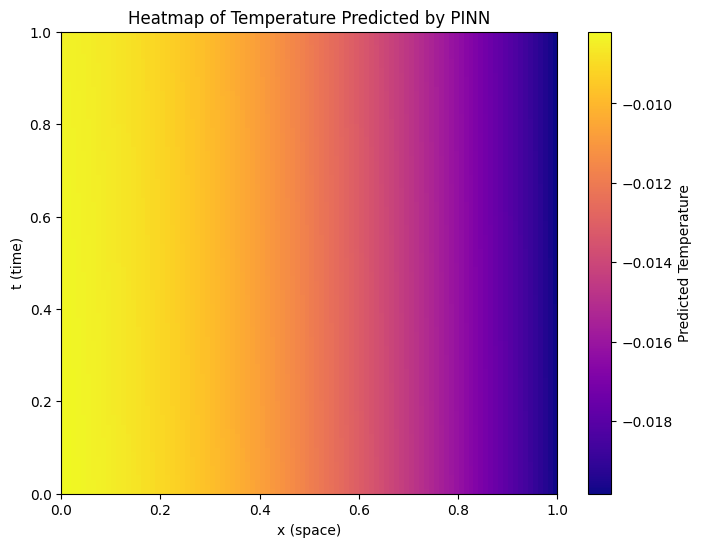

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(T_pred_grid, extent=[0, 1, 0, 1], origin='lower', aspect='auto', cmap='plasma')
plt.colorbar(label="Predicted Temperature")
plt.xlabel("x (space)")
plt.ylabel("t (time)")
plt.title("Heatmap of Temperature Predicted by PINN")
plt.show()


# **3D Surface Plot**

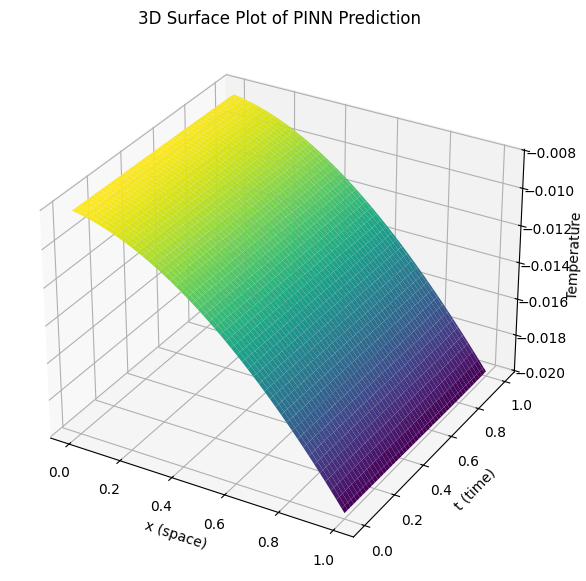

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, T_pred_grid, cmap='viridis', edgecolor='none')
ax.set_xlabel("x (space)")
ax.set_ylabel("t (time)")
ax.set_zlabel("Temperature")
ax.set_title("3D Surface Plot of PINN Prediction")
plt.show()


# **Animation**

In [ ]:
# import matplotlib.animation as animation

# # Set up the figure and axis
# fig, ax = plt.subplots(figsize=(8, 5))
# line, = ax.plot([], [], lw=2)
# ax.set_xlim(0, 1)
# ax.set_ylim(-0.1, 1.1)
# ax.set_xlabel('x (space)')
# ax.set_ylabel('Temperature')
# ax.set_title('Temperature Evolution Over Time (PINN Prediction)')

# # Generate spatial points for x
# x_vals = torch.linspace(0, 1, 200).reshape(-1, 1)
# x_vals_np = x_vals.detach().numpy()

# # Function to initialize the animation
# def init():
#     line.set_data([], [])
#     return line,

# # Function to update the plot for each frame
# def animate(frame):
#     t_val = torch.full_like(x_vals, frame / 100)  # Vary time from 0 to 1
#     input_tensor = torch.cat([x_vals, t_val], dim=1)
#     with torch.no_grad():
#         T_vals = model(input_tensor).detach().numpy()

#     line.set_data(x_vals_np, T_vals)
#     ax.set_title(f'Temperature at t = {frame/100:.2f}')
#     return line,

# # Create the animation
# ani = animation.FuncAnimation(fig, animate, init_func=init, frames=100, interval=100, blit=True)

# plt.show()


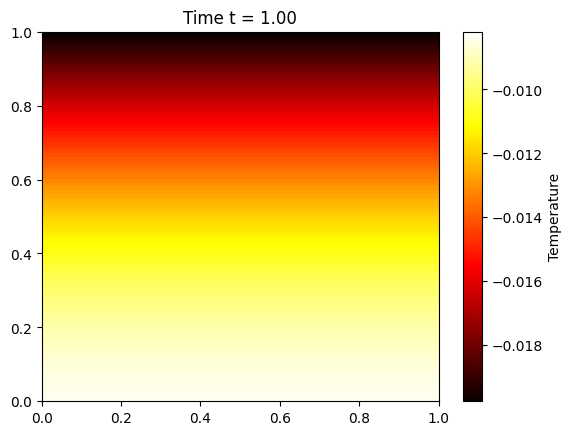

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set up the grid for x and t
x_vals = torch.linspace(0, 1, 100)
t_vals = torch.linspace(0, 1, 100)
X, T = torch.meshgrid(x_vals, t_vals, indexing='ij')

# Flatten and prepare input for the model
XT = torch.cat([X.reshape(-1, 1), T.reshape(-1, 1)], dim=1).requires_grad_(True)

# Get the model's prediction
with torch.no_grad():
    predictions = model(XT).reshape(100, 100).cpu().numpy()

# Plotting the results as an animation
fig, ax = plt.subplots()
cax = ax.imshow(predictions[:, 0].reshape(100, 1), cmap='hot', origin='lower',
                extent=[0, 1, 0, 1], aspect='auto')
fig.colorbar(cax, label="Temperature")

def animate(i):
    cax.set_data(predictions[:, i].reshape(100, 1))
    ax.set_title(f"Time t = {t_vals[i].item():.2f}")
    return [cax]

ani = animation.FuncAnimation(fig, animate, frames=100, interval=100, blit=True)

# ✅ Display the animation in Google Colab
HTML(ani.to_jshtml())


In [ ]:
# Example input values for x and t
x_input = torch.tensor([[0.5]])  # e.g., x = 0.5 (middle of the domain)
t_input = torch.tensor([[0.5]])  # e.g., t = 0.5 (middle of the time domain)

# Concatenate x and t
input_tensor = torch.cat([x_input, t_input], dim=1).float()

# Make the prediction using the trained model
with torch.no_grad():  # Disable gradient tracking for evaluation
    output_T = model(input_tensor)

# Print the predicted temperature value
print(f"Predicted Temperature at x = {x_input.item()} and t = {t_input.item()} is T = {output_T.item()}")


Predicted Temperature at x = 0.5 and t = 0.5 is T = -0.011879950761795044


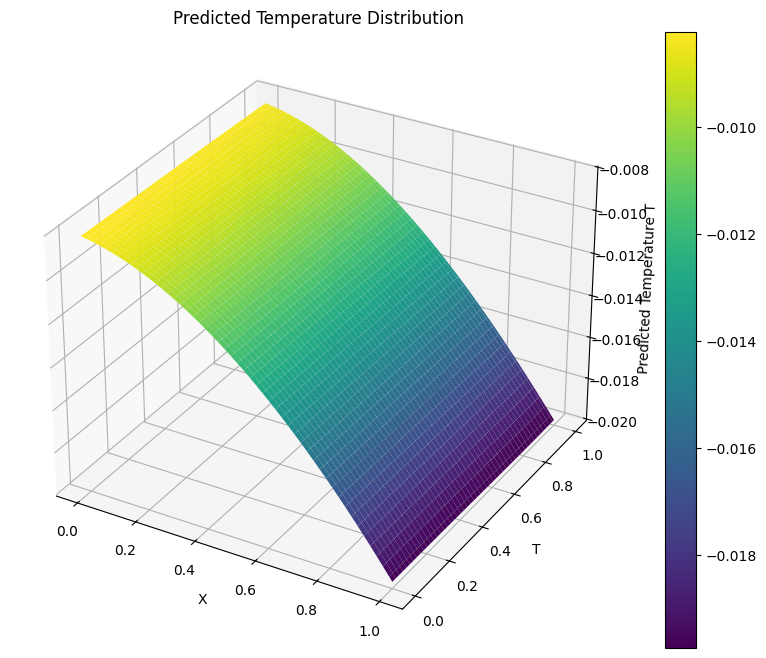

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a grid of x and t values
x_vals = np.linspace(0, 1, 100)  # x from 0 to 1
t_vals = np.linspace(0, 1, 100)  # t from 0 to 1
X, T = np.meshgrid(x_vals, t_vals)  # Create a meshgrid of x and t

# Convert the grid to a tensor and concatenate x and t
inputs = np.vstack([X.flatten(), T.flatten()]).T
inputs_tensor = torch.tensor(inputs, dtype=torch.float32)

# Make predictions for all the points in the grid
with torch.no_grad():
    predictions = model(inputs_tensor)  # Get predicted temperatures

# Reshape the predictions to match the shape of the meshgrid
T_pred = predictions.numpy().reshape(X.shape)

# Plotting
fig = plt.figure(figsize=(10, 8))

# 3D Surface Plot
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, T, T_pred, cmap='viridis', edgecolor='none')
ax.set_xlabel('X')
ax.set_ylabel('T')
ax.set_zlabel('Predicted Temperature T')
ax.set_title('Predicted Temperature Distribution')

# Add color bar
fig.colorbar(surf)

plt.show()


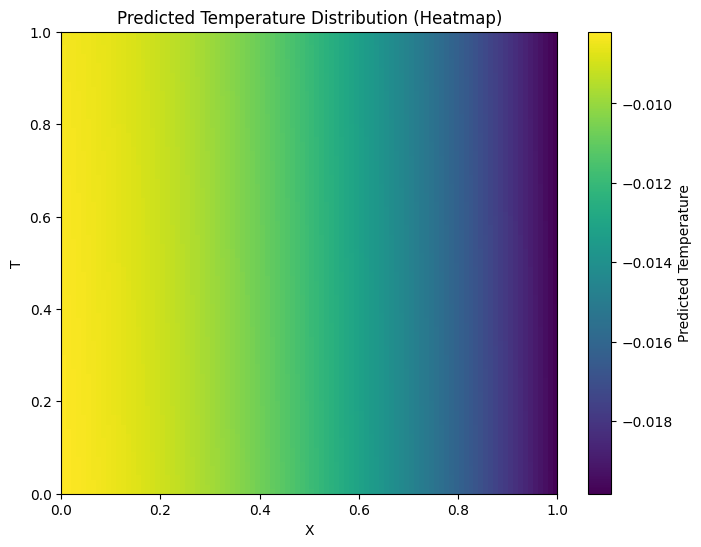

In [ ]:
# Plotting Heatmap (2D)
plt.figure(figsize=(8, 6))
plt.imshow(T_pred, extent=[0, 1, 0, 1], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Predicted Temperature')
plt.xlabel('X')
plt.ylabel('T')
plt.title('Predicted Temperature Distribution (Heatmap)')
plt.show()


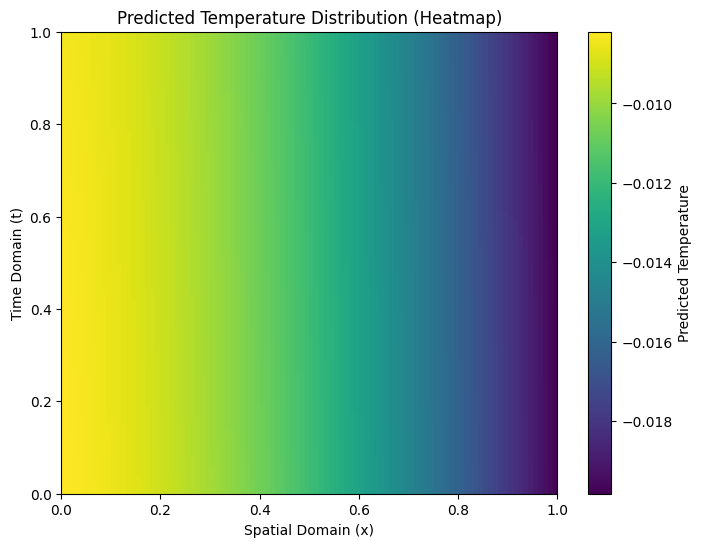

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Create a grid of x and t values
x_vals = np.linspace(0, 1, 100)  # x from 0 to 1
t_vals = np.linspace(0, 1, 100)  # t from 0 to 1
X, T = np.meshgrid(x_vals, t_vals)  # Create a meshgrid of x and t

# Convert the grid to a tensor and concatenate x and t
inputs = np.vstack([X.flatten(), T.flatten()]).T
inputs_tensor = torch.tensor(inputs, dtype=torch.float32)

# Make predictions for all the points in the grid
with torch.no_grad():
    predictions = model(inputs_tensor)  # Get predicted temperatures

# Reshape the predictions to match the shape of the meshgrid
T_pred = predictions.numpy().reshape(X.shape)

# Plotting Heatmap (2D)
plt.figure(figsize=(8, 6))
plt.imshow(T_pred, extent=[0, 1, 0, 1], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Predicted Temperature')
plt.xlabel('Spatial Domain (x)')
plt.ylabel('Time Domain (t)')
plt.title('Predicted Temperature Distribution (Heatmap)')
plt.show()


# **Define the Exact Solution**

In [ ]:
# Define the exact solution for the heat equation
def exact_solution(x, t, alpha=0.01):
    return np.exp(-np.pi**2 * alpha * t) * np.sin(np.pi * x)


# **Generate Exact Solution on a Grid**

In [ ]:
# Create a grid of x and t values
x_vals = np.linspace(0, 1, 100)  # x from 0 to 1
t_vals = np.linspace(0, 1, 100)  # t from 0 to 1
X, T = np.meshgrid(x_vals, t_vals)  # Create a meshgrid of x and t

# Compute the exact solution
exact_T = exact_solution(X, T)


In [ ]:
print('x=',x_vals)
print('t=',t_vals)
print('exact_T=',exact_T)


x= [0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89

# **Compare the PINN Predictions with Exact Solution**

In [ ]:
# Convert the grid to a tensor and concatenate x and t
inputs = np.vstack([X.flatten(), T.flatten()]).T
inputs_tensor = torch.tensor(inputs, dtype=torch.float32)

# Get the predicted temperatures from the PINN model
with torch.no_grad():
    predicted_T = model(inputs_tensor).numpy().reshape(X.shape)

# Now you have both `exact_T` (exact solution) and `predicted_T` (from PINN) on the same grid.


# **Visualization of the Comparison**


# ***Plot 1: Exact Solution vs Predicted Solution (Heatmaps)***

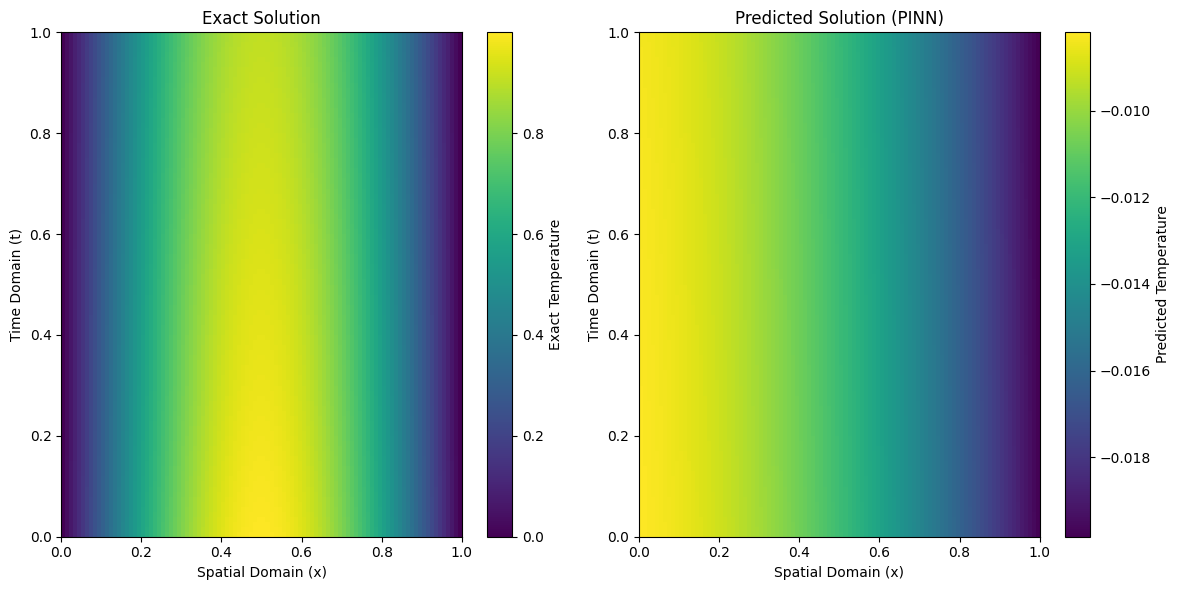

In [ ]:
# Plot the exact solution heatmap
plt.figure(figsize=(12, 6))

# Exact solution
plt.subplot(1, 2, 1)
plt.imshow(exact_T, extent=[0, 1, 0, 1], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Exact Temperature')
plt.title('Exact Solution')
plt.xlabel('Spatial Domain (x)')
plt.ylabel('Time Domain (t)')

# Predicted solution
plt.subplot(1, 2, 2)
plt.imshow(predicted_T, extent=[0, 1, 0, 1], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Predicted Temperature')
plt.title('Predicted Solution (PINN)')
plt.xlabel('Spatial Domain (x)')
plt.ylabel('Time Domain (t)')

plt.tight_layout()
plt.show()


# ***Plot 2: Difference Between Exact and Predicted Solutions***

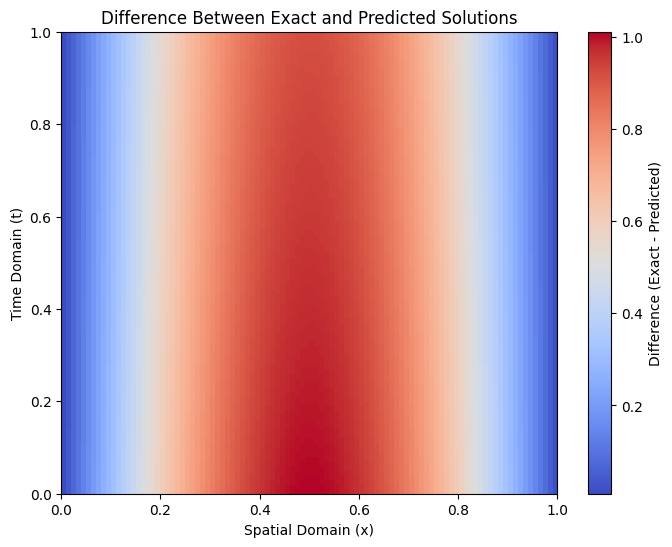

In [ ]:
# Compute the difference between the exact and predicted solutions
difference = exact_T - predicted_T

# Plot the difference heatmap
plt.figure(figsize=(8, 6))
plt.imshow(difference, extent=[0, 1, 0, 1], origin='lower', aspect='auto', cmap='coolwarm')
plt.colorbar(label='Difference (Exact - Predicted)')
plt.title('Difference Between Exact and Predicted Solutions')
plt.xlabel('Spatial Domain (x)')
plt.ylabel('Time Domain (t)')
plt.show()


# **Compute and Display the Error Metrics**

In [ ]:
# Compute the L2 error (mean squared error) between exact and predicted solutions
error = np.linalg.norm(exact_T - predicted_T) / np.linalg.norm(exact_T)
print(f"Relative L2 Error: {error}")


Relative L2 Error: 1.0164731696386464
